In [1]:
import logging
import warnings
from collections import defaultdict
from dataclasses import dataclass
from pprint import pprint

import qcportal
import openeye # these two lines prevent zstd header error

import numpy as np
from openff.qcsubmit import workflow_components
from openff.qcsubmit.factories import TorsiondriveDatasetFactory
from openff.qcsubmit.workflow_components import TorsionIndexer
from openff.toolkit import ForceField, Molecule
from openff.toolkit.utils import GLOBAL_TOOLKIT_REGISTRY, OpenEyeToolkitWrapper
from tqdm import tqdm

In [2]:
# Warnings that tell us we have undefined stereo and charged molecules
logging.getLogger("openff.toolkit").setLevel(logging.ERROR)
warnings.simplefilter("ignore")

In [3]:
# deregister openeye wrapper to use rdkit throughout
GLOBAL_TOOLKIT_REGISTRY.deregister_toolkit(OpenEyeToolkitWrapper)

In [4]:
from rdkit.Chem.Draw import MolsToGridImage, rdDepictor, rdMolDraw2D

def draw_rdkit(rdmol, matches):
    rdDepictor.SetPreferCoordGen(True)
    rdDepictor.Compute2DCoords(rdmol)
    rdmol = rdMolDraw2D.PrepareMolForDrawing(rdmol)
    mols = [rdmol for _ in matches]
    return MolsToGridImage(
        mols,
        useSVG=True,
        highlightAtomLists=matches,
        subImgSize=(300, 300),
        molsPerRow=2,
    )

In [5]:
def manual_atoms(smiles, param):
    "Convert a set of SMILES and display them to pick specific torsions"
    mols = [Molecule.from_smiles(s, allow_undefined_stereo=True) for s in smiles]
    for m in mols:
        labels = ff.label_molecules(m.to_topology())[0]["ProperTorsions"]
        atom_indices = [k for k, v in labels.items() if v.id == param]
        print(atom_indices)
        display(draw_rdkit(m.to_rdkit(), atom_indices))
    return mols

In [6]:
def add_torsion(mol, atom_indices):
    torsion_indexer = TorsionIndexer()
    torsion_indexer.add_torsion(atom_indices, (0, 3), (-165, 180))
    mol.properties["dihedrals"] = torsion_indexer

# Dataset Preparation

## Load Smiles and Force Field

In [7]:
p_smiles = defaultdict(list) # pid -> [smiles]
with open("all.smiles") as inp:
    for line in inp:
        [pid, smiles] = line.split() # lines of "pid smiles"
        p_smiles[pid].append(smiles)

print(f"loaded {sum((len(v) for v in p_smiles.values()))} smiles for {len(p_smiles)} parameters")

ff = ForceField("tm.v2.offxml")

loaded 46 smiles for 25 parameters


## Tag the torsions to drive

### Select non-ring torsions

[(18, 21, 36, 35), (18, 21, 36, 37), (22, 21, 36, 35), (22, 21, 36, 37)]


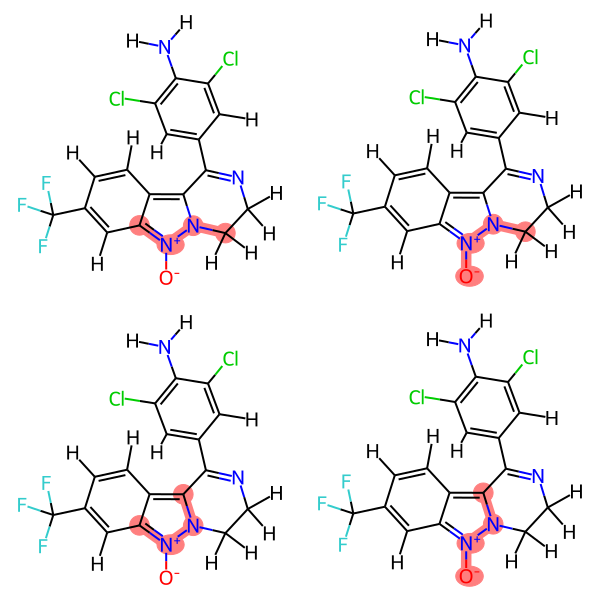

[(17, 22, 20, 19), (17, 22, 20, 21), (19, 20, 22, 23), (21, 20, 22, 23)]


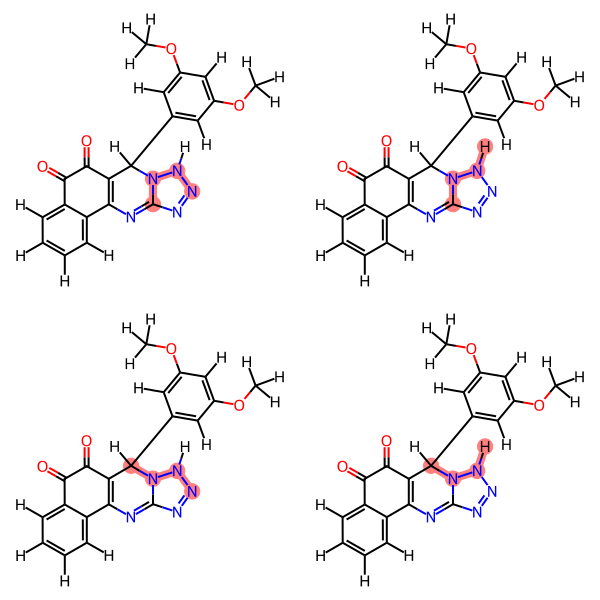

In [8]:
molecules: list[Molecule] = []
t141b_mols = manual_atoms(p_smiles["t141b"], "t141b")
assert len(t141b_mols) == 2, len(t141b_mols)
add_torsion(t141b_mols[0], (18, 21, 36, 37))
add_torsion(t141b_mols[1], (17, 22, 20, 21))
molecules.extend(t141b_mols)
del p_smiles["t141b"]

[(7, 10, 13, 14), (11, 10, 13, 14), (12, 10, 13, 14)]


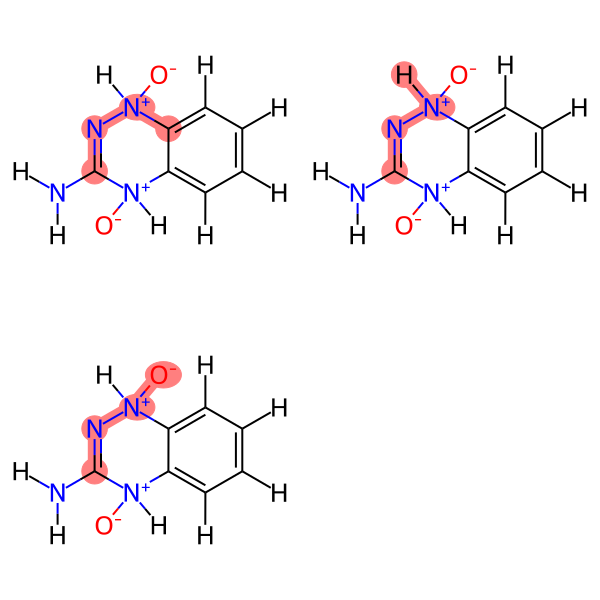

[(2, 4, 5, 6), (2, 4, 5, 13), (2, 4, 5, 20)]


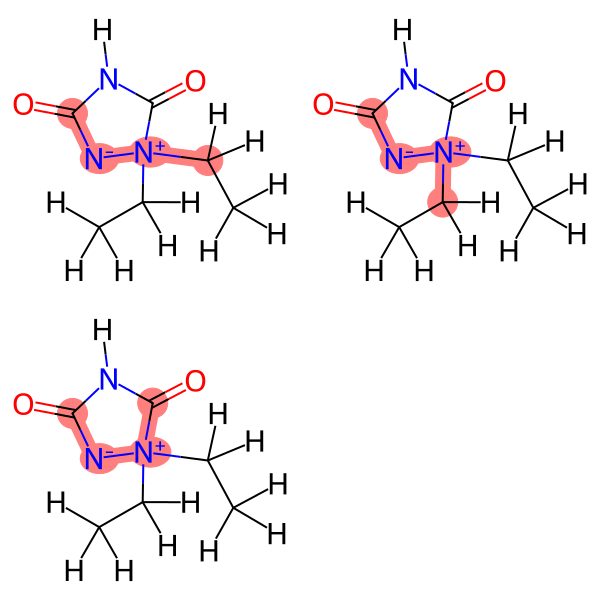

In [9]:
t138a_mols = manual_atoms(p_smiles["t138a"], "t138a")
assert len(t138a_mols) == 2
add_torsion(t138a_mols[0], (11, 10, 13, 14))
add_torsion(t138a_mols[1], (2, 4, 5, 6))
molecules.extend(t138a_mols)
del p_smiles["t138a"]

labeling molecules:   0%|                                                                      | 0/23 [00:00<?, ?it/s]

t133g


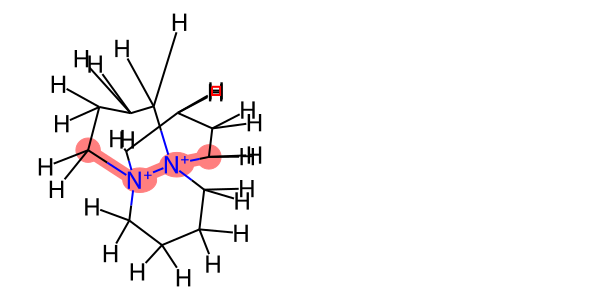

t18b


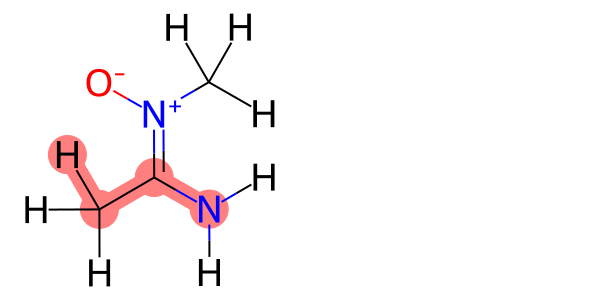

t18b


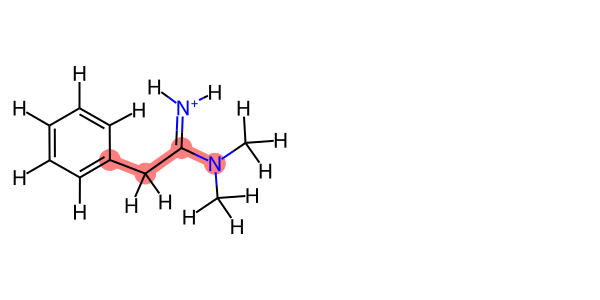

labeling molecules:   9%|█████▍                                                        | 2/23 [00:00<00:02,  8.42it/s]

t87a


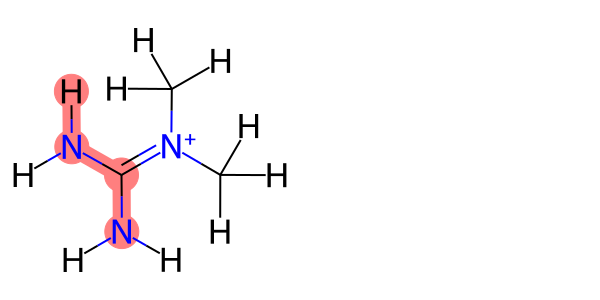

t87a


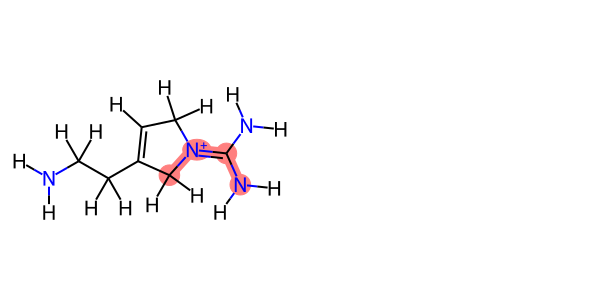

labeling molecules:  13%|████████                                                      | 3/23 [00:00<00:02,  7.78it/s]

t130h


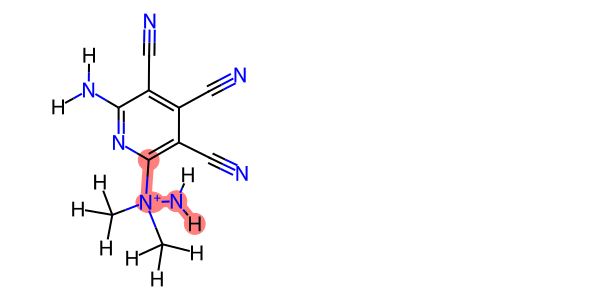

t120h


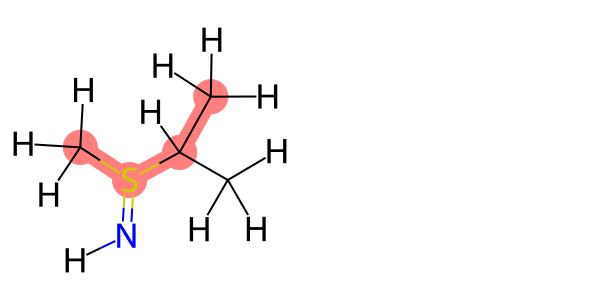

t120h


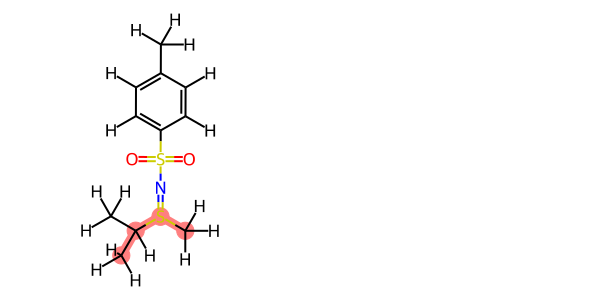

labeling molecules:  22%|█████████████▍                                                | 5/23 [00:00<00:02,  7.97it/s]

t119h


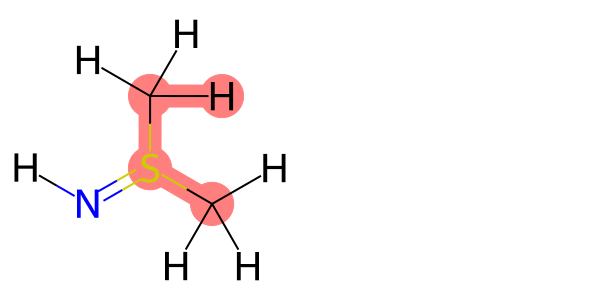

t119h


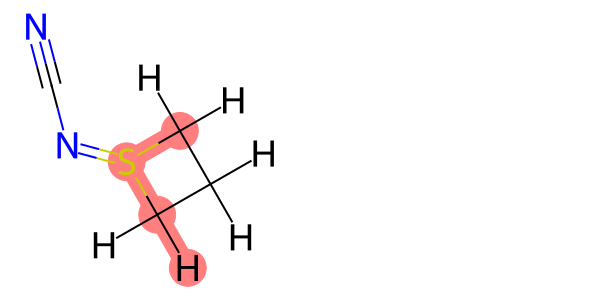

labeling molecules:  26%|████████████████▏                                             | 6/23 [00:00<00:02,  7.87it/s]

t62g


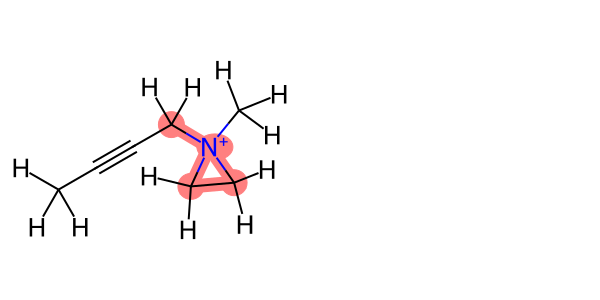

t62g


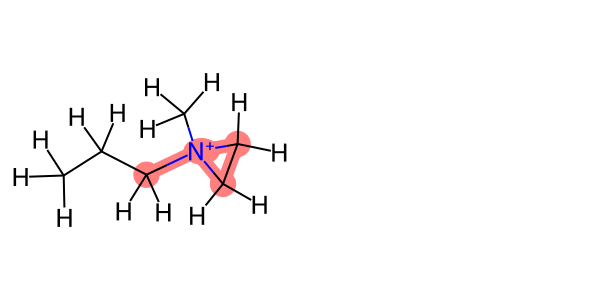

labeling molecules:  30%|██████████████████▊                                           | 7/23 [00:01<00:02,  6.20it/s]

t133h


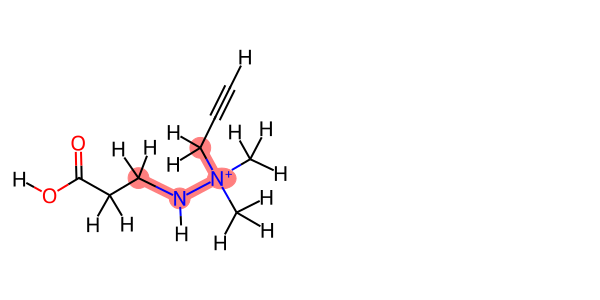

t133h


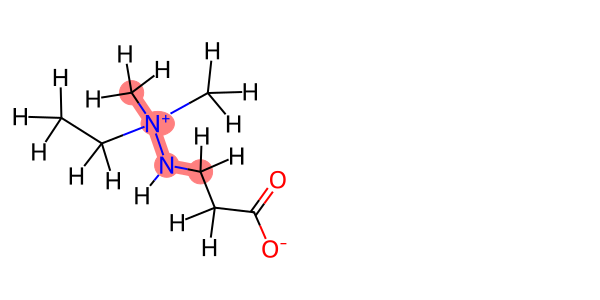

labeling molecules:  35%|█████████████████████▌                                        | 8/23 [00:01<00:02,  6.29it/s]

t61g


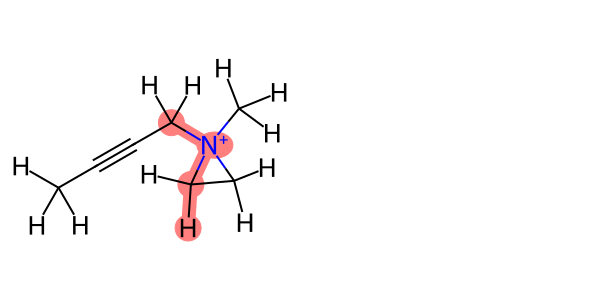

t61g


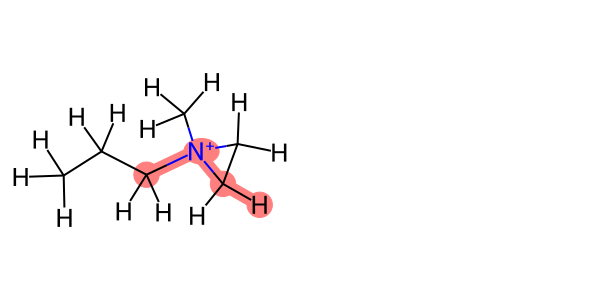

labeling molecules:  39%|████████████████████████▎                                     | 9/23 [00:01<00:02,  6.58it/s]

t132h


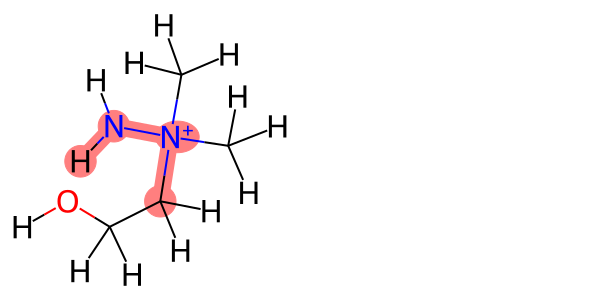

t132h


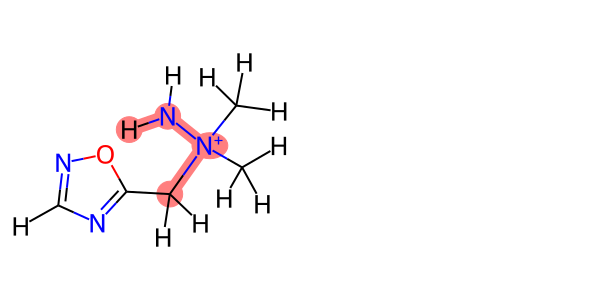

labeling molecules:  43%|██████████████████████████▌                                  | 10/23 [00:01<00:01,  6.81it/s]

t118h


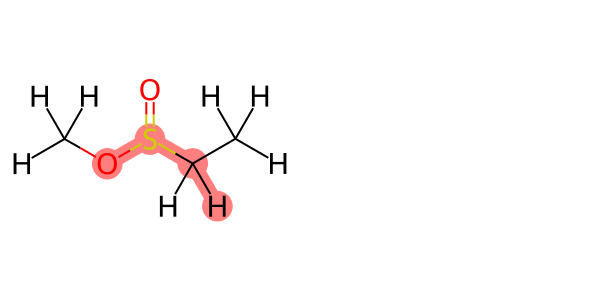

t142j


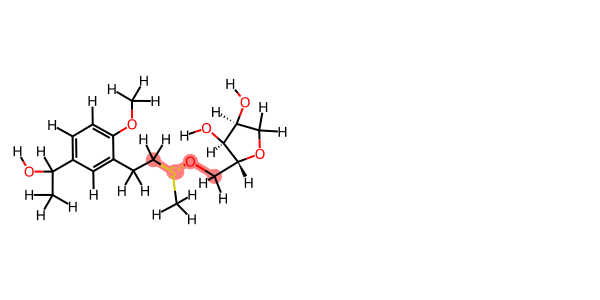

t142j


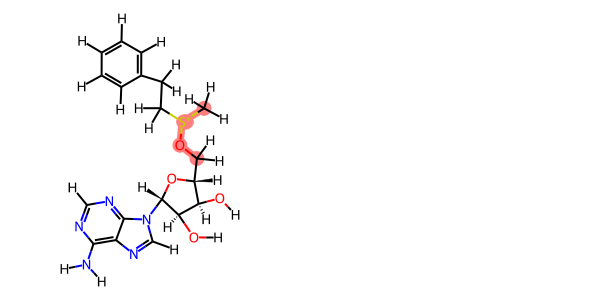

labeling molecules:  52%|███████████████████████████████▊                             | 12/23 [00:01<00:01,  7.32it/s]

t116i


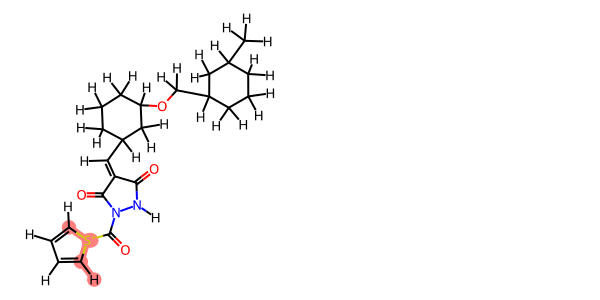

t89


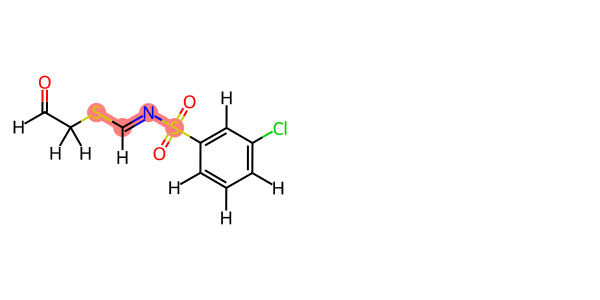

t89


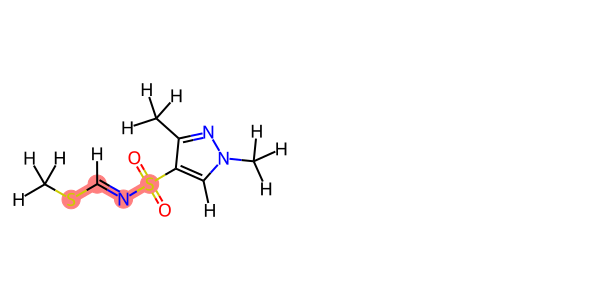

labeling molecules:  61%|█████████████████████████████████████▏                       | 14/23 [00:01<00:01,  7.67it/s]

t142k


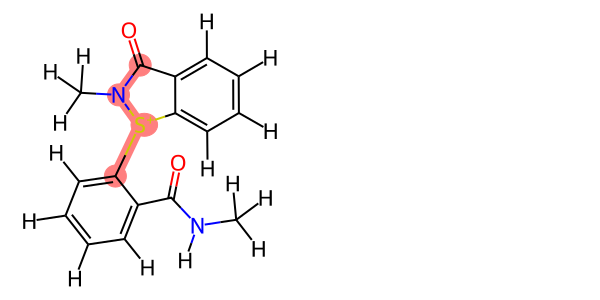

t142k


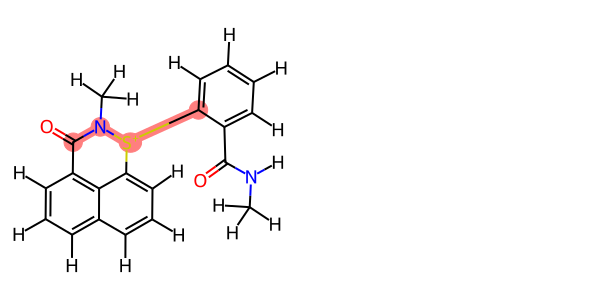

labeling molecules:  65%|███████████████████████████████████████▊                     | 15/23 [00:02<00:01,  7.26it/s]

t101


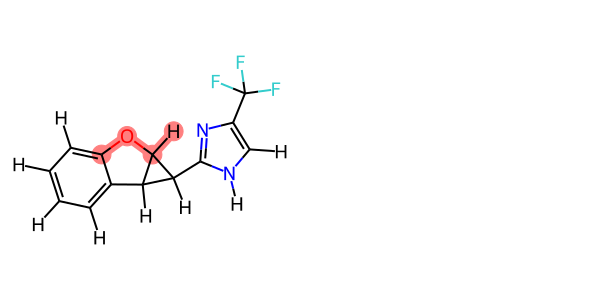

t101


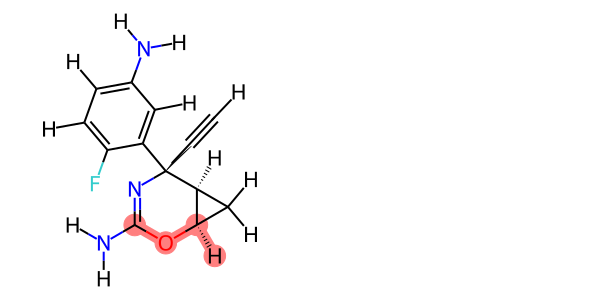

labeling molecules:  70%|██████████████████████████████████████████▍                  | 16/23 [00:02<00:00,  7.08it/s]

t141


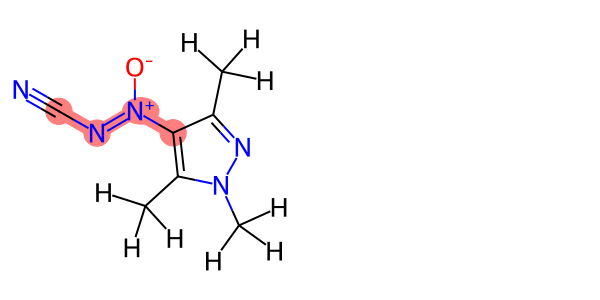

t141


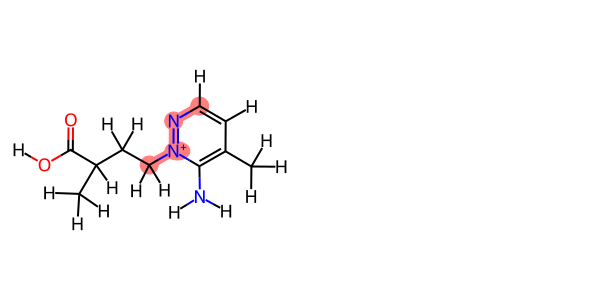

labeling molecules:  74%|█████████████████████████████████████████████                | 17/23 [00:02<00:00,  6.94it/s]

t88


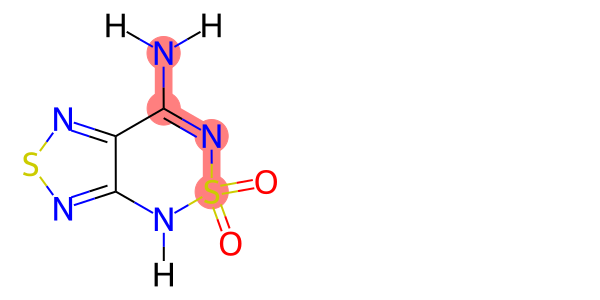

t88


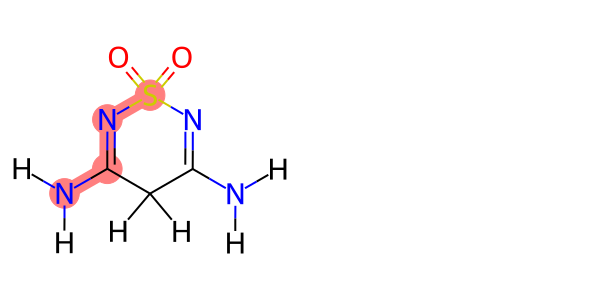

labeling molecules:  78%|███████████████████████████████████████████████▋             | 18/23 [00:02<00:00,  7.09it/s]

t18a


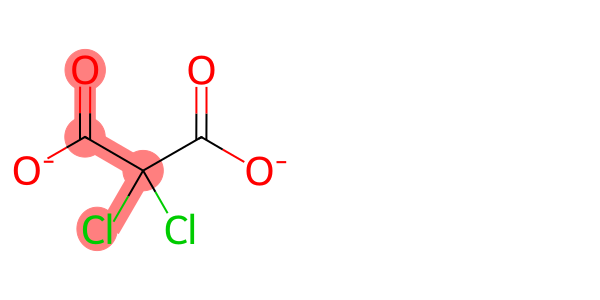

t18a


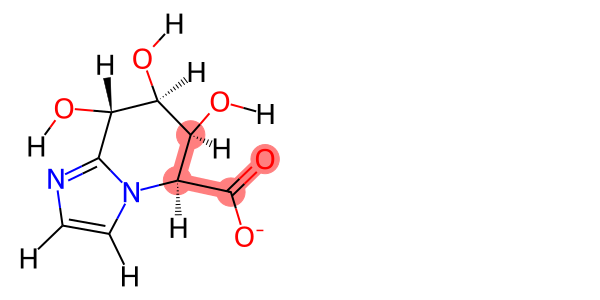

labeling molecules:  83%|██████████████████████████████████████████████████▍          | 19/23 [00:02<00:00,  7.17it/s]

t116j


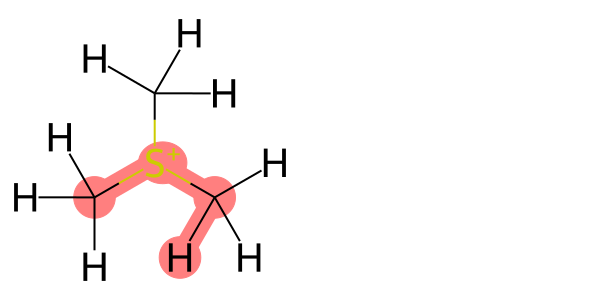

t116j


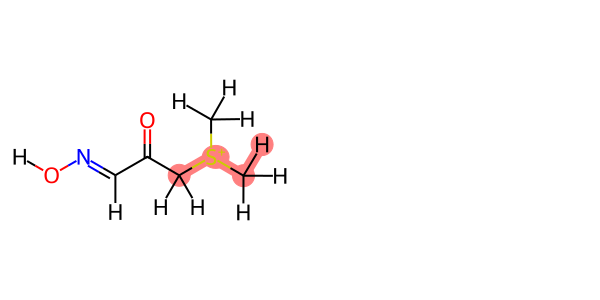

labeling molecules:  87%|█████████████████████████████████████████████████████        | 20/23 [00:02<00:00,  7.19it/s]

t72h


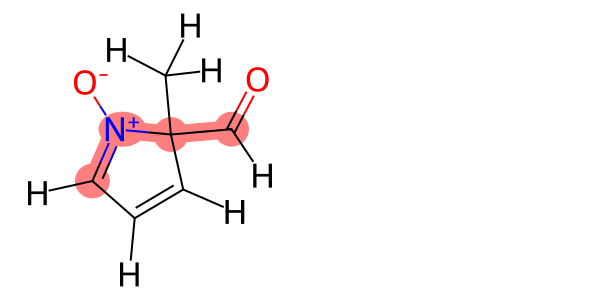

t72h


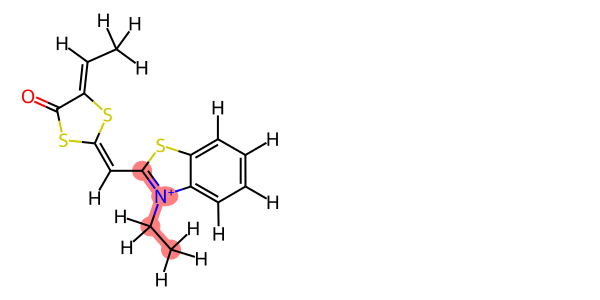

labeling molecules:  91%|███████████████████████████████████████████████████████▋     | 21/23 [00:02<00:00,  7.04it/s]

t115h


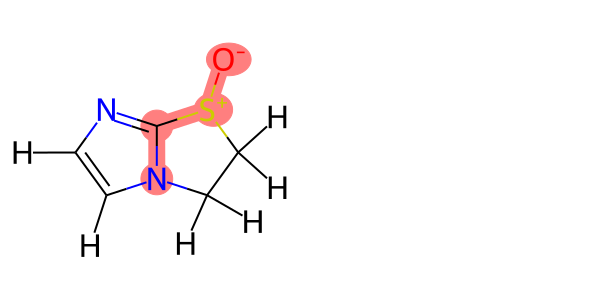

t115h


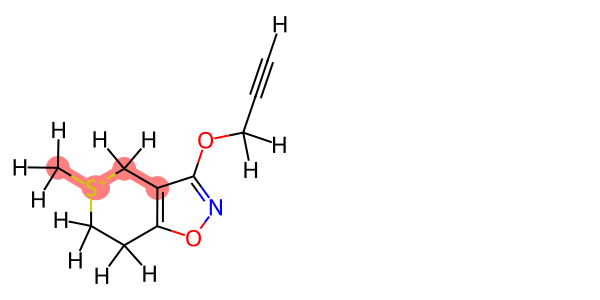

labeling molecules:  96%|██████████████████████████████████████████████████████████▎  | 22/23 [00:03<00:00,  7.13it/s]

t83h


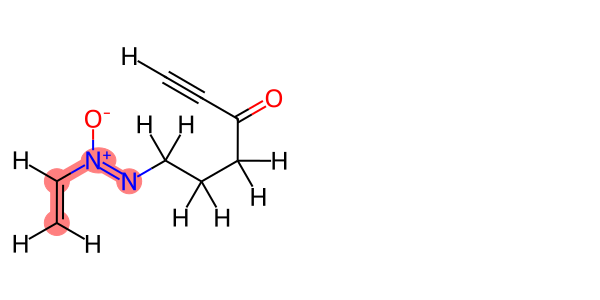

t83h


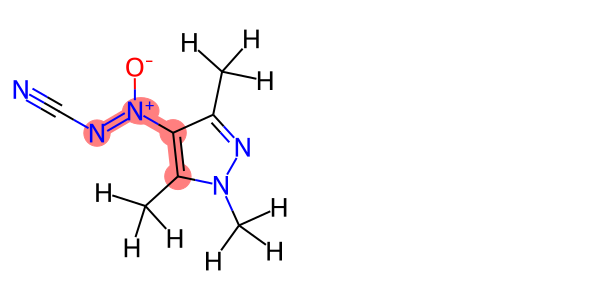

labeling molecules: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  7.14it/s]

tagged 46 molecules


In [10]:
# adapted from 2022-04-29-OpenFF-multiplicity-correction-torsion-drive-data
# in the function create_tagged_molecules

for pid, smiles in tqdm(p_smiles.items(), desc="labeling molecules"):
    for smile in smiles:
        mol = Molecule.from_smiles(smile, allow_undefined_stereo=True)
        labels = ff.label_molecules(mol.to_topology())[0]["ProperTorsions"]
        for atom_indices in (k for k, v in labels.items() if v.id == pid):
            print(pid)
            display(draw_rdkit(mol.to_rdkit(), [atom_indices]))
            torsion_indexer = TorsionIndexer()
            torsion_indexer.add_torsion(atom_indices, (0, 3), (-165, 180))
            mol.properties["dihedrals"] = torsion_indexer
            molecules.append(mol)
            break # so Pavan only takes one from each, at most
        else:
            print(f"never found a match for {pid}")

print(f"tagged {len(molecules)} molecules")

# Prepare the dataset

Again, this is adapted from [the OpenFF multiplicity correction notebook][example]

[example]: https://github.com/openforcefield/qca-dataset-submission/blob/08ace97758087f06cf22a986fc9ee838f72edae7/submissions/2022-04-29-OpenFF-multiplicity-correction-torsion-drive-data/Dataset_Generation.ipynb

In [11]:
dataset_factory = TorsiondriveDatasetFactory()
dataset_factory.add_workflow_components(workflow_components.StandardConformerGenerator(max_conformers=10))

# 2024-01-31-OpenFF-Torsion-Coverage-Supplement-v1.0
dataset = dataset_factory.create_dataset(
    dataset_name="OpenFF Torsion Coverage Supplement v1.0",
    tagline="OpenFF Torsion Coverage Supplement v1.0",
    description="Additional coverage for Sage 2.1.0 proper torsions and new parameters from the torsion multiplicity work",
    molecules=molecules,
)

dataset.metadata.submitter = "ntBre"
dataset.metadata.long_description_url = (
    "https://github.com/openforcefield/qca-dataset-submission/tree/master/"
    "submissions/"
    "2024-01-31-OpenFF-Torsion-Coverage-Supplement-v1.0"
)

StandardConformerGenerator    :   0%|                    | 0/43 [00:00<?, ?it/s][12:31:32] UFFTYPER: Unrecognized charge state for atom: 22
[12:31:32] UFFTYPER: Unrecognized charge state for atom: 31
[12:31:32] UFFTYPER: Unrecognized charge state for atom: 7
StandardConformerGenerator    :   2%|▎           | 1/43 [00:00<00:09,  4.31it/s][12:31:32] UFFTYPER: Unrecognized charge state for atom: 4
[12:31:32] UFFTYPER: Unrecognized charge state for atom: 10
[12:31:32] UFFTYPER: Unrecognized charge state for atom: 7
[12:31:32] UFFTYPER: Unrecognized charge state for atom: 15
Preparation                   :   0%|                    | 0/43 [00:00<?, ?it/s][12:31:32] WARNING: Charges were rearranged

[12:31:32] WARNING: Charges were rearranged

[12:31:33] WARNING: Charges were rearranged

[12:31:33] WARNING: Charges were rearranged

Preparation                   :   9%|█           | 4/43 [00:00<00:01, 35.35it/s][12:31:33] WARNING: Charges were rearranged

[12:31:33] WARNING: Charges were rearr

# Summarize the dataset
Make sure the molecules in the dataset match the input molecules

In [12]:
old_smiles = set()
for _pid, smiles in p_smiles.items():
    for smile in smiles:
        try:
            old_smiles.add(Molecule.from_smiles(smile, allow_undefined_stereo=True).to_smiles(isomeric=False))
        except AssertionError:
            # same issue as above
            continue

new_smiles = {molecule.to_smiles(isomeric=False) for molecule in dataset.molecules}

diff = len(old_smiles.symmetric_difference(new_smiles))
assert diff == 4, f"{diff} ! = 4" # 4 manual smiles

Describe the molecules in the dataset

In [13]:
confs = np.array([len(mol.conformers) for mol in dataset.molecules])

print("Number of unique molecules       ", dataset.n_molecules)
print("Number of filtered molecules     ", dataset.n_filtered)
print("Number of conformers             ", dataset.n_records)
print("Number of conformers min mean max",
      confs.min(), "{:6.2f}".format(confs.mean()), confs.max())

# thanks matt for updating this section in #344
masses = [
    [
        sum([atom.mass.m for atom in molecule.atoms])
        for molecule in dataset.molecules
    ]
]
print(f'Mean molecular weight: {np.mean(np.array(masses)):.2f}')
print(f'Max molecular weight: {np.max(np.array(masses)):.2f}')
print("Charges:", sorted(set(m.total_charge.m for m in dataset.molecules)))

Number of unique molecules        43
Number of filtered molecules      0
Number of conformers              43
Number of conformers min mean max 1   1.88 7
Mean molecular weight: 202.95
Max molecular weight: 431.57
Charges: [-2.0, -1.0, 0.0, 1.0, 2.0]


Describe the dataset

In [14]:
pprint(dataset.metadata.dict())

{'collection_type': 'TorsionDriveDataset',
 'creation_date': datetime.date(2024, 2, 28),
 'dataset_name': 'OpenFF Torsion Coverage Supplement v1.0',
 'elements': {'S', 'N', 'H', 'C', 'Cl', 'O', 'F'},
 'long_description': 'Additional coverage for Sage 2.1.0 proper torsions and '
                     'new parameters from the torsion multiplicity work',
 'long_description_url': HttpUrl('https://github.com/openforcefield/qca-dataset-submission/tree/master/submissions/2024-01-31-OpenFF-Torsion-Coverage-Supplement-v1.0', ),
 'short_description': 'OpenFF Torsion Coverage Supplement v1.0',
 'submitter': 'ntBre'}


In [15]:
for spec, obj in dataset.qc_specifications.items():
    print("Spec:", spec)
    pprint(obj.dict())

Spec: default
{'basis': 'DZVP',
 'implicit_solvent': None,
 'keywords': None,
 'maxiter': 200,
 'method': 'B3LYP-D3BJ',
 'program': 'psi4',
 'scf_properties': ['dipole',
                    'quadrupole',
                    'wiberg_lowdin_indices',
                    'mayer_indices'],
 'spec_description': 'Standard OpenFF optimization quantum chemistry '
                     'specification.',
 'spec_name': 'default',
 'store_wavefunction': 'none'}


In [16]:
pprint(dataset.qc_specifications['default'].scf_properties)

[<SCFProperties.Dipole: 'dipole'>,
 <SCFProperties.Quadrupole: 'quadrupole'>,
 <SCFProperties.WibergLowdinIndices: 'wiberg_lowdin_indices'>,
 <SCFProperties.MayerIndices: 'mayer_indices'>]


Export the dataset.

In [17]:
dataset.export_dataset("dataset.json.bz2")
dataset.molecules_to_file("dataset.smi", "smi")

GLOBAL_TOOLKIT_REGISTRY.register_toolkit(OpenEyeToolkitWrapper)
dataset.visualize("dataset.pdf", columns=8)